توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

Omid Jafaei 401204268

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
import os
os.makedirs('../my_dataset')

In [ ]:
## download data
#%%capture
!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip -d '../my_dataset'
!unzip release_test.zip -d '../my_dataset'
!pip install mmengine

In [ ]:
!ls '../my_dataset'

ADEChallengeData2016  release_test


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path
from tqdm import tqdm
from torch.utils.data import Dataset, ConcatDataset, TensorDataset
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
from torchvision import transforms

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
# function 1
def displacement(img):

  ## To Do
  pil_img = transforms.ToPILImage()(img)
  width, height = pil_img.size
  midpoint = width // 2
  left_side = pil_img.crop((0, 0, midpoint, height))
  right_side = pil_img.crop((midpoint, 0, width, height))
  swapped_img = Image.new("RGB", (width, height))
  swapped_img.paste(right_side, (0, 0))
  swapped_img.paste(left_side, (midpoint, 0))
  swapped_tensor = transforms.ToTensor()(swapped_img)
  return swapped_tensor


# function 2
def rotation(img):

  ## To Do
  angle = 45
  pil_img = transforms.ToPILImage()(img)
  rotated_pil_img = pil_img.rotate(angle)
  rotated_tensor = transforms.ToTensor()(rotated_pil_img)
  return rotated_tensor


# function 3
def scaling(img):
  ## To Do
  a = randint(1,2)
  if a == 1:
     zoom_factor = 0.7
  else:
     zoom_factor = 3

  pil_img = transforms.ToPILImage()(img)
  original_size = pil_img.size
  new_size = tuple(int(dim * zoom_factor) for dim in original_size)
  zoomed_pil_img = pil_img.resize(new_size, Image.BICUBIC)
  zoomed_tensor = transforms.ToTensor()(zoomed_pil_img)
  return zoomed_tensor



# function 4
def Brightness(img):  ## for augmentation
  ## To Do
  pil = transforms.ToPILImage()(img)
  pil = transforms.functional.adjust_brightness(pil, brightness_factor = 2)
  adjusted_img = transforms.ToTensor()(pil)
  return adjusted_img

# function 5
def bluring(img):# for augmentation
  ## To Do
  pil = transforms.ToPILImage()(img)
  pil=transforms.functional.gaussian_blur(pil, kernel_size=7, sigma=1.5)
  blurred_imgs = transforms.ToTensor()(pil)
  return blurred_imgs

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do
  mean = 0
  std = 0.1
  noise = torch.randn(img.shape) * std + mean
  noisy_img = torch.clamp(img + noise, 0, 1)
  return noisy_img

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, y, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir)
        self.image_list = os.listdir(self.image_dir)
        self.y = y

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        aug_transform1 = transforms.Compose([transforms.Lambda(lambda x: Brightness(x))])
        aug_transform2 = transforms.Compose([transforms.Lambda(lambda x: bluring(x))])
        aug_transform3 = transforms.Compose([transforms.Lambda(lambda x: gaussian_noise(x))])

        transform1 = transforms.Compose([transforms.Lambda(lambda x: displacement(x))])
        transform2 = transforms.Compose([transforms.Lambda(lambda x: rotation(x))])
        transform3 = transforms.Compose([transforms.Lambda(lambda x: scaling(x))])
        crop = transforms.Compose([transforms.CenterCrop((224, 224))])
        resize = transforms.Compose([transforms.Resize((224, 224))])

        unchanged_images = crop(image.clone())

        d = randint(1,6)
        if d == 1:
          image = aug_transform1(image)
        elif d == 2:
          image = aug_transform2(image)
        elif d == 3:
          image = aug_transform3(image)


        c = randint(1,7)
        if c == 1:
          image = transform1(image)
          image = crop(image)
          self.y[idx] = torch.tensor([1, 0., 0.])
        elif c == 2:
          image = transform2(image)
          image = crop(image)
          self.y[idx] = torch.tensor([0., 1, 0.])
        elif c == 3:
          image = transform3(image)
          image = crop(image)
          self.y[idx] = torch.tensor([0., 0., 1])
        elif c == 4:
          image = transform1(image)
          image = transform2(image)
          image = crop(image)
          self.y[idx] = torch.tensor([1, 1, 0.])
        elif c == 5:
          image = transform1(image)
          image = transform3(image)
          image = crop(image)
          self.y[idx] = torch.tensor([1, 0., 1])
        elif c == 6:
          image = transform2(image)
          image = transform3(image)
          image = crop(image)
          self.y[idx] = torch.tensor([0., 1, 1])
        else:
          image = transforms.Resize((224,224))(image)
          self.y[idx] = torch.tensor([0., 0., 0.])


        return {'unchanged_image': unchanged_images, 'changed_image': image, 'label': self.y[idx]}

![image.png](attachment:7ccfbfb1-e62f-46f3-be80-38c6b2df7e4d.png)

![image.png](attachment:ba030adc-f403-46f9-980e-eead4b2890ab.png)

In [ ]:
root_dir_train = '../my_dataset/ADEChallengeData2016/images/training'
root_dir_val = '../my_dataset/ADEChallengeData2016/images/validation'
root_dir_test = '../my_dataset/release_test/testing'


transform_train = transforms.Compose([transforms.ToTensor()])

y_train = torch.zeros((20210,3))
y_test = torch.zeros((3352,3))
y_val = torch.zeros((2000,3))

dataset_train = CustomDataset(y_train, root_dir=root_dir_train, transform=transform_train)## To Do
dataset_test = CustomDataset(y_test, root_dir=root_dir_test, transform=transform_train)## To Do
dataset_val = CustomDataset(y_test, root_dir=root_dir_val, transform=transform_train)## To Do


batch_size = 16
torch.manual_seed(45)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)## To Do
torch.manual_seed(45)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)## To Do
torch.manual_seed(45)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)## To Do

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


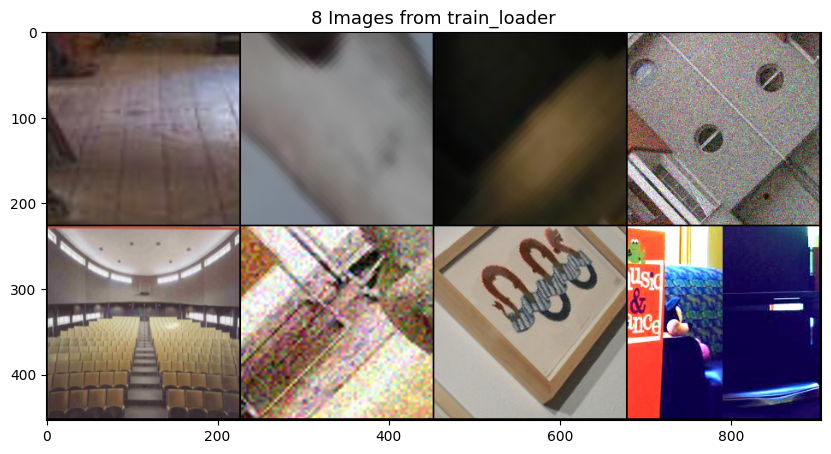

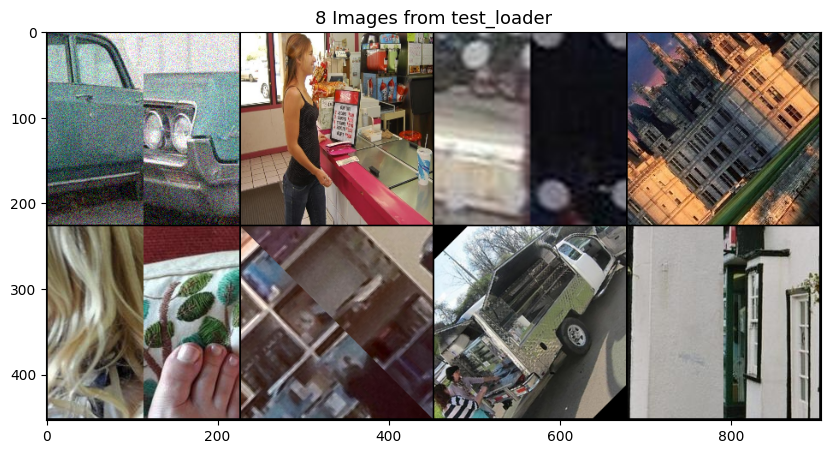

In [ ]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

train_images = next(iter(train_loader))
train_images_to_display = train_images['changed_image'][0:8]
train_image_grid = make_grid(train_images_to_display, nrow=4)
train_image_grid_np = train_image_grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(train_image_grid_np)
plt.title('8 Images from train_loader', fontsize=13)
plt.show()
##########################################################
test_images = next(iter(test_loader))
test_images_to_display = test_images['changed_image'][0:8]
test_image_grid = make_grid(test_images_to_display, nrow=4)
test_image_grid_np = test_image_grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(test_image_grid_np)
plt.title('8 Images from test_loader', fontsize=13)
plt.show()

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

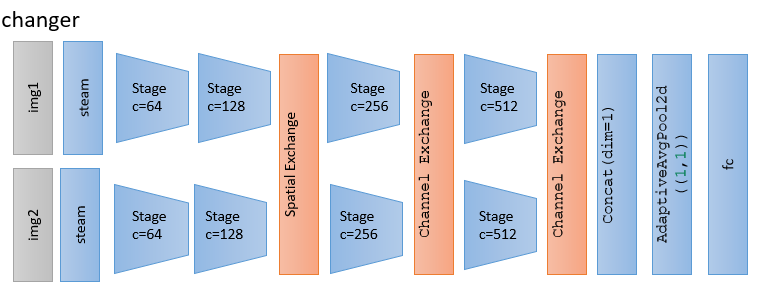

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


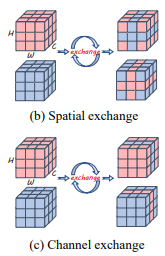

In [ ]:
## dont change this block
!pip install mmengine
from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

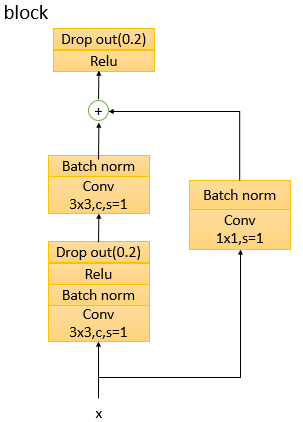

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





1- channel out size (conv(1x1)) = c , چون باید با تعداد کانال های مسیر مستقیم برابر باشد تا بتوانند با هم جمع شوند.


2- padding(conv) = 1, برای هر لایه کانولوشنی پدینگ 1 از هرطرف در نظر گفته شده است تا ابعاد خروجی H, W برابر با ورودی بماند.

In [ ]:
##To Do
class block(nn.Module):
  def __init__(self, input_channels = None, c = None):
    super(block,self).__init__()
    self.input_channels = input_channels
    self.conv_layer = nn.Sequential(nn.Conv2d(in_channels = self.input_channels, out_channels = c, kernel_size = 3, stride = 1, padding = 1),
                                    nn.BatchNorm2d(num_features = c),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Conv2d(in_channels = c, out_channels = c, kernel_size = 3, stride = 1, padding = 1),
                                    nn.BatchNorm2d(num_features = c))


    self.skip_layer = nn.Sequential(nn.Conv2d(in_channels = self.input_channels, out_channels = c, kernel_size = 1, stride = 1, padding = 0),
                                    nn.BatchNorm2d(num_features = c))

    self.output = nn.Sequential(nn.ReLU(),
                                nn.Dropout(0.2))


  def forward(self,x):
      y1 = self.conv_layer(x)
      y2 = self.skip_layer(x)
      out = self.output(y1 + y2)
      return out

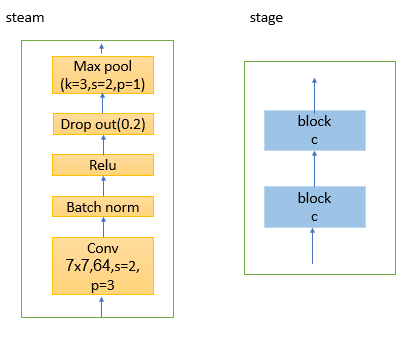

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam1=nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3),
                             nn.BatchNorm2d(num_features = 64),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
                             )
    self.steam2=nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3),
                             nn.BatchNorm2d(num_features = 64),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
                             )



    self.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((1, 1))


    self.stage11=self._make_stage(64, 64)
    self.stage21=self._make_stage(64, 128)
    self.stage31=self._make_stage(128, 256)
    self.stage41=self._make_stage(256, 512)

    self.stage12=self._make_stage(64, 64)
    self.stage22=self._make_stage(64, 128)
    self.stage32=self._make_stage(128, 256)
    self.stage42=self._make_stage(256, 512)

  def get_output(self, network):
    dummy_input = torch.randn(1, 3, 256, 256)
    output = network(dummy_input)

    return output

  def _make_stage(self, input_c, ouput_c):

    layers=[block(input_c, ouput_c), block(ouput_c, ouput_c)]

    return nn.Sequential(*layers)


  def forward(self,x1,x2):
     x1 = self.steam1(x1)
     x1 = self.stage11(x1)
     x1 = self.stage21(x1)

     x2 = self.steam2(x2)
     x2 = self.stage12(x2)
     x2 = self.stage22(x2)

     spatial_exchange = SpatialExchange()
     x1, x2 = spatial_exchange.forward(x1, x2)

     x1 = self.stage31(x1)
     x2 = self.stage32(x2)

     channel_exchange1 = ChannelExchange()
     x1, x2 = channel_exchange1.forward(x1, x2)

     x1 = self.stage41(x1)
     x2 = self.stage42(x2)

     channel_exchange2 = ChannelExchange()
     x1, x2 = channel_exchange2.forward(x1, x2)

     y = torch.cat((x1, x2), dim=1)
     y = self.AdaptiveAvgPool2d(y)
     flatten_y = torch.flatten(y, start_dim = 1)

     out = nn.Sequential(
     nn.Linear(in_features=flatten_y.shape[1], out_features=3)
     ,nn.Softmax(dim=1))
     out = out.to(device)

     return  out(flatten_y)

In [ ]:
## To Do
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
model=changer(block,SpatialExchange,ChannelExchange)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer= Adam(model.parameters(), lr = 1e-4)

##Train & validation


In [ ]:
epochs = 4
Loss_train=[]
Loss_val=[]
acc_list_train = []
acc_list_val = []
for epoch in range(epochs):
    batch_loss = []
    batch_acc = []
    model.train()
    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for t, imgs in enumerate(epoch_progress):
            x1 = imgs['unchanged_image']
            x2 = imgs['changed_image']
            y = imgs['label']
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            y_pred = model(x1, x2)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            y_pred[y_pred >= (1/3)] = 1
            y_pred[y_pred < (1/3)] = 0
            accuracy = (y_pred == y).sum()/(batch_size*3)*100
            batch_acc.append(accuracy)
            del x1, x2, y, y_pred, loss, accuracy
            torch.cuda.empty_cache()
        Loss_train.append(sum(batch_loss) / len(batch_loss))
        acc_list_train.append(float(sum(batch_acc)/len(batch_acc)))
        print(f'Epoch {epoch + 1}/{epochs}, Loss_train: {Loss_train[-1]:.4f}, Accuracy: {acc_list_train[-1]:.4f}')

batch_loss = []
batch_acc = []
model.eval()
with tqdm(val_loader, desc=f'Valdidation Phase', unit='batch', leave=False) as epoch_progress:
    for t, imgs in enumerate(epoch_progress):
        x1 = imgs['unchanged_image']
        x2 = imgs['changed_image']
        y = imgs['label']
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y_pred = model(x1, x2)
        loss = criterion(y_pred, y)
        batch_loss.append(loss.item())
        y_pred[y_pred >= (1/3)] = 1
        y_pred[y_pred < (1/3)] = 0
        accuracy = (y_pred == y).sum()/(batch_size*3)*100
        batch_acc.append(accuracy)
        del x1, x2, y, y_pred, loss, accuracy
        torch.cuda.empty_cache()
    Loss_val.append(sum(batch_loss) / len(batch_loss))
    acc_list_val.append(float(sum(batch_acc)/len(batch_acc)))
    print(f'Loss_val: {Loss_val[-1]:.4f}, Accuracy: {acc_list_val[-1]:.4f}')

Epoch 1/4, Loss_train: 1.4090, Accuracy: 50.2340


Epoch 2/4, Loss_train: 1.4082, Accuracy: 50.0824


Epoch 3/4, Loss_train: 1.4209, Accuracy: 50.1170


Epoch 4/4, Loss_train: 1.4069, Accuracy: 50.3642


Loss_val: 1.4166, Accuracy: 50.2000


In [ ]:
torch.save({
    'epochs': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'Loss_train': Loss_train,
    'Loss_val': Loss_val,
    'acc_list_train': acc_list_train,
    'acc_list_val': acc_list_train
}, 'model.pth')

#Test


In [ ]:
checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epochs']
Loss_train = checkpoint['Loss_train']
Loss_val = checkpoint['Loss_val']
## To Do test
Loss_test=[]
acc_list_test = []
batch_loss = []
batch_acc = []
model.eval()
with tqdm(test_loader, desc=f'Test Phase', unit='batch', leave=False) as epoch_progress:
    for t, imgs in enumerate(epoch_progress):
        x1 = imgs['unchanged_image']
        x2 = imgs['changed_image']
        y = imgs['label']
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y_pred = model(x1, x2)
        loss = criterion(y_pred, y)
        batch_loss.append(loss.item())
        y_pred[y_pred >= (1/3)] = 1
        y_pred[y_pred < (1/3)] = 0
        accuracy = (y_pred == y).sum()/(batch_size*3)*100
        batch_acc.append(accuracy)
        del x1, x2, loss, accuracy
        torch.cuda.empty_cache()
    Loss_test.append(sum(batch_loss) / len(batch_loss))
    acc_list_test.append(float(sum(batch_acc)/len(batch_acc)))
    print(f'Loss_test: {Loss_test[-1]:.4f}, Accuracy: {acc_list_test[-1]:.4f}')



Loss_test: 1.4320, Accuracy: 51.5079


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [ ]:
y

tensor([[0., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 1., 1.]], device='cuda:0')

In [ ]:
y_pred

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], device='cuda:0', grad_fn=<IndexPutBackward0>)